Now I will connect to the database, and run some SQL queries to get some basic information about the features I am interested in. 

In [3]:
import pprint
import csv
import sqlite3
sqlite_file = 'data.db'    # name of the sqlite database file

conn = sqlite3.connect(sqlite_file)     # Connect to the database
cur = conn.cursor()    # Get a cursor object

In [251]:
# Get an idea about the number of restaurants
cur.execute('SELECT COUNT(*) FROM nodes_tags WHERE nodes_tags.value= "restaurant" GROUP BY nodes_tags.id')
print (len(cur.fetchall()))

2889


In [17]:
# Explore number of restaurants of a partcular cuisine say thai

cur.execute('''
SELECT nodes.id, nodes_tags.key, nodes_tags.value
FROM nodes, nodes_tags 
WHERE (nodes.id = nodes_tags.id) AND 
-- (lower(nodes_tags.key) = 'cuisine') AND 
(lower(nodes_tags.value) like "thai")
GROUP BY nodes.id
''')
pprint.pprint(len(cur.fetchall()))

106


In [73]:
   # Query for restaurants 
cur.execute('''
SELECT nodes.lat, nodes.lon
FROM nodes, nodes_tags 
WHERE (nodes.id=nodes_tags.id) AND 
      (nodes_tags.key='cuisine') AND 
      (lower(nodes_tags.value) like "%french%")
GROUP BY nodes.id, nodes.lat, nodes.lon
''')
rows1 = cur.fetchall()
pprint.pprint(len(rows1))

38


In [69]:
   # Query for coffee shops, cafes and tea places
    
cur.execute('''
SELECT nodes.lat, nodes.lon
FROM nodes, nodes_tags 
WHERE (nodes.id=nodes_tags.id) AND 
      --(nodes_tags.key='cuisine') AND 
      ((lower(nodes_tags.value) like "%coffee%") or (lower(nodes_tags.value) like "%cafe%") or (lower(nodes_tags.value) like "%tea%"))
      GROUP BY nodes.id, nodes.lat, nodes.lon
''')
rows1 = cur.fetchall()
pprint.pprint(len(rows1))

1381


In [71]:
   # Query for amenities such as gas station, schools, library, church
    
cur.execute('''
SELECT nodes.lat, nodes.lon
FROM nodes, nodes_tags 
WHERE (nodes.id=nodes_tags.id) AND 
      (nodes_tags.key='amenity') AND 
      lower(nodes_tags.value) like "%school%"
GROUP BY nodes.id, nodes.lat, nodes.lon
''')
rows1 = cur.fetchall()
pprint.pprint(len(rows1))

586



  __Choosing Clustering Algorithm:__

* The k-means algorithm is a common clustering algorithm. For spatial data, the [DBSCAN algorithm](http://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs) is more appropriate.
 
* k-means is not an ideal algorithm for latitude-longitude spatial data because it minimizes variance, not geodetic distance. There is substantial distortion at latitudes far from the equator.

* DBSCAN can handle arbitrary distance function and clusters a spatial data set based on two parameters: a physical distance from each point, and a minimum cluster size. 

* __The epsilon parameter__ is the max distance that points can be from each other to be considered in a cluster. __The min_samples parameter__ is the minimum cluster size (everything else gets classified as noise). 

* In DBSCAN you don't have to specify the number of clusters in advance. It determines them based on the epsilon and min_samples parameters

* The silhouette score is a measure of how similar a point is to its own cluster compared to other clusters.The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster.

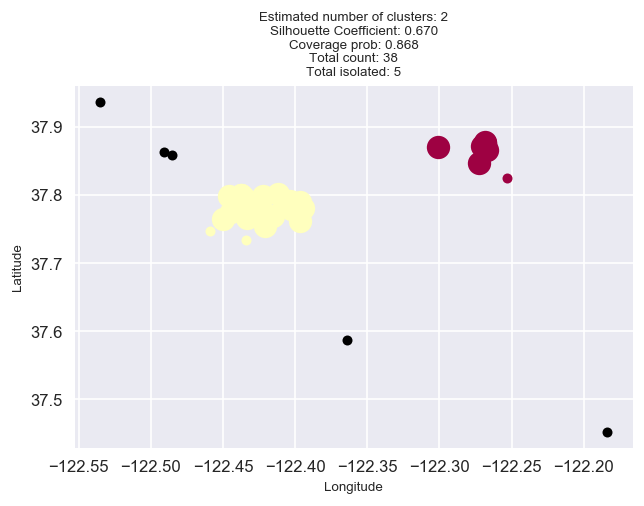

           2          3          4          5
0  (6, 0.21)   (4, 0.1)  (4, 0.07)  (2, -0.1)
1  (3, 0.49)  (2, 0.49)  (2, 0.49)  (2, 0.49)
2  (3, 0.66)  (2, 0.67)  (2, 0.67)  (2, 0.67)
3  (3, 0.66)  (2, 0.67)  (2, 0.67)  (2, 0.67)
4  (3, 0.66)  (2, 0.67)  (2, 0.67)  (2, 0.67)
5  (3, 0.66)  (2, 0.67)  (2, 0.67)  (2, 0.67)
6  (3, 0.66)  (2, 0.67)  (2, 0.67)  (2, 0.67)
7   (2, 0.7)   (2, 0.7)   (2, 0.7)   (2, 0.7)
8  (2, 0.73)  (2, 0.73)  (2, 0.73)  (2, 0.73)


In [74]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import math
from sklearn.cluster import DBSCAN
from sklearn import metrics
%matplotlib inline

def cluster(data, n_epsilon, min_samples):
    kms_per_radian = 6371.0088    # convert kilometers to radians for use by haversine
    radian_coords_df = np.radians(data)
    epsilon = n_epsilon / kms_per_radian
    return DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(radian_coords_df)
    
def cluster_and_plot(data_points_df, n_epsilon, min_samples):
    db = cluster(data_points_df, n_epsilon, min_samples)
    labels = db.labels_
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_isolated_ = sum([1 if label == -1 else 0 for label in labels])

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    fig = plt.figure(dpi=120)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data_points_df[class_member_mask & core_samples_mask]
        plt.plot(xy['lon'], xy['lat'], 'o', markerfacecolor=col,
                 markeredgecolor=col, markersize=14)

        xy = data_points_df[class_member_mask & ~core_samples_mask]
        plt.plot(xy['lon'], xy['lat'], 'o', markerfacecolor=col,
                 markeredgecolor=col, markersize=6)

    total_data_points = len(data_points_df)
    plt.title('Estimated number of clusters: %d\nSilhouette Coefficient: %0.3f\nCoverage prob: %0.3f\nTotal count: %d\nTotal isolated: %d' 
              % (n_clusters_, metrics.silhouette_score(data_points_df, labels), 1 - float(n_isolated_)/total_data_points, total_data_points, n_isolated_), 
             fontsize = 8)
    plt.ylabel ('Latitude', fontsize = 8)
    plt.xlabel ('Longitude', fontsize = 8)
    plt.grid(True)
    plt.show()
    
coords_df = pd.DataFrame(rows1, columns = ['lat','lon'])
cluster_and_plot(coords_df, 3, 4)
# cluster_and_plot(coords_df, 0.8, 2)   # 2 points within 1/2 mile 

#pprint.pprint(int(max(2, 2.0/38 * len(coords_df))))
#cluster_and_plot(coords_df, 3, int(max(2, 2.0/38 * len(coords_df))))   # 2 points within 1/2 mile 

all_results = []
for eps in range(1, 10):
    row = []
    for min_samp in range(2, 6):
        result = cluster(coords_df, eps, min_samp)
        n_clusters_ = len(set(result.labels_)) - (1 if -1 in result.labels_ else 0)
        coeff = str(round(metrics.silhouette_score(coords_df, result.labels_), 2))
        row.append((n_clusters_, coeff))
    all_results.append(row)
pprint.pprint(pd.DataFrame(all_results, columns=range(2, 6)))

In [66]:
cur.execute('''
SELECT uid,  user, count(*) as count_num_nodes
FROM (SELECT nodes.id as id, nodes.uid as uid, nodes.user as user 
    FROM nodes, nodes_tags 
    WHERE nodes.id = nodes_tags.id 
    GROUP BY nodes.id, nodes.uid, nodes.user
   ) as node_user_pair
GROUP BY uid
ORDER BY count_num_nodes DESC
LIMIT 10;
''')
rows = cur.fetchall()
pprint.pprint(rows)

[(933797, u'oba510', 11719),
 (169004, u'oldtopos', 7301),
 (371121, u'AndrewSnow', 6412),
 (1295, u'robert', 5644),
 (153669, u'dchiles', 5482),
 (11154, u'beej71', 4074),
 (481533, u'dbaron', 3720),
 (14293, u'KindredCoda', 3565),
 (28775, u'StellanL', 3467),
 (22925, u'ELadner', 3021)]


In [67]:
cur.execute('''
SELECT topUsers.uid, topUsers.user, tags.value as value, count(*) as tag_value_count 
FROM ( 
    SELECT uid,  user, count(*) as count_num_nodes
    FROM (SELECT nodes.id as id, nodes.uid as uid, nodes.user as user 
        FROM nodes, nodes_tags 
        WHERE nodes.id = nodes_tags.id 
        GROUP BY nodes.id, nodes.uid, nodes.user
       ) as node_user_pair
    GROUP BY uid
    ORDER BY count_num_nodes DESC
    LIMIT 10
    ) topUsers, nodes, nodes_tags as tags
WHERE topUsers.uid = nodes.uid AND nodes.id = tags.id and tags.key = 'amenity'
GROUP BY topUsers.uid, topUsers.user, value
ORDER BY tag_value_count desc
''')
rows_user = cur.fetchall()
pprint.pprint(rows_user)

[(371121, u'AndrewSnow', u'restaurant', 249),
 (153669, u'dchiles', u'restaurant', 151),
 (153669, u'dchiles', u'bicycle_parking', 128),
 (371121, u'AndrewSnow', u'cafe', 111),
 (169004, u'oldtopos', u'restaurant', 92),
 (481533, u'dbaron', u'restaurant', 74),
 (153669, u'dchiles', u'bench', 71),
 (14293, u'KindredCoda', u'restaurant', 64),
 (169004, u'oldtopos', u'bench', 59),
 (933797, u'oba510', u'cafe', 57),
 (11154, u'beej71', u'bench', 51),
 (153669, u'dchiles', u'drinking_water', 51),
 (153669, u'dchiles', u'cafe', 47),
 (169004, u'oldtopos', u'post_box', 47),
 (14293, u'KindredCoda', u'place_of_worship', 46),
 (11154, u'beej71', u'drinking_water', 43),
 (933797, u'oba510', u'restaurant', 43),
 (153669, u'dchiles', u'waste_basket', 38),
 (14293, u'KindredCoda', u'school', 36),
 (28775, u'StellanL', u'bench', 36),
 (371121, u'AndrewSnow', u'dentist', 36),
 (153669, u'dchiles', u'post_box', 34),
 (481533, u'dbaron', u'post_box', 34),
 (153669, u'dchiles', u'bicycle_rental', 30),
 

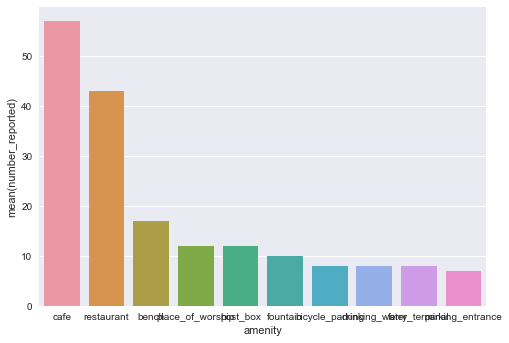

In [68]:
import pandas as pd
import seaborn as sns
# store query results in a dataframe
user_df = pd.DataFrame(rows_user, columns = ['uid','name', 'amenity','number_reported'])

topuser_df = user_df[user_df['name'] == 'oba510']
g = sns.barplot(x='amenity', y='number_reported', data = topuser_df[:10])
sns.plt.show()

In [ ]:
user2_df = user_df[user_df['name'] == 'oldtopos']
g = sns.barplot(x='amenity', y='number_reported', data = user2_df[:10])
sns.plt.show()
user3_df = user_df[user_df['name'] == 'AndrewSnow']
g = sns.barplot(x='amenity', y='number_reported', data = user3_df[:10])
sns.plt.show()
user4_df = user_df[user_df['name'] == 'dchiles']
g = sns.barplot(x='amenity', y='number_reported', data = user4_df[:10])
sns.plt.show()
user5_df = user_df[user_df['name'] == 'KindredCoda']
g = sns.barplot(x='amenity', y='number_reported', data = user5_df[:10])
sns.plt.show()
user6_df = user_df[user_df['name'] == 'StellanL']
g = sns.barplot(x='amenity', y='number_reported', data = user6_df[:10])
sns.plt.show()